In [88]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import pickle

In [89]:
def mapear_a_puntaje(valor):
    if valor == -1:
        return 0  # Descalificado
    elif valor == 0:
        return 62.5  # Calidad Media (promedio de 50-74)
    elif valor == 1:
        return 87.5  # Calidad Alta (promedio de 75-100)

In [90]:
df = pd.read_csv('Datos_Train_Calidad_Lead_Clean.csv')
df.head()

,Cuota_Inicial__c,Presupuesto_inmueble_a_comprar__c,ingresos_totales__c,Ingresos_familiares__c,Calidad_de_lead__c,picklist_ciudad__c
0,7000000.0,3.000000e+08,5000000.0,5000000.0,-1,1
1,2000000.0,2.000000e+08,2800000.0,2800000.0,-1,1
2,4000000.0,2.488307e+08,1000000.0,1000000.0,-1,1
3,1000000.0,1.800000e+07,1800000.0,1800000.0,-1,1
4,0.0,1.700000e+08,3000000.0,3000000.0,-1,1


In [91]:
# Mapear la columna 'Calidad_de_lead__c' a 'Calidad_de_lead_score'
df['Puntaje_de_calidad'] = df['Calidad_de_lead__c'].apply(mapear_a_puntaje)

In [92]:
# Separar las columnas de entrada y la salida
X = df.drop(['Calidad_de_lead__c', 'Puntaje_de_calidad'], axis=1)
y = df['Puntaje_de_calidad']

In [93]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [94]:
# Normalizar los datos
escalador = StandardScaler()
X_train = escalador.fit_transform(X_train)
X_test = escalador.transform(X_test)

In [95]:
# Definir los modelos
modelos = {
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'SVR': SVR()
}

In [96]:
# Definir los hiperparámetros a probar
parametros_grid = {
    'RandomForestRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'GradientBoostingRegressor': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 0.9, 1.0]
    },
    'LinearRegression': {
        'fit_intercept': [True, False],
    },
    'SVR': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto'],
        'epsilon': [0.1, 0.2, 0.5]
    }
}

# Definir un scorer basado en mean_absolute_error
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Buscar los mejores hiperparámetros para cada modelo
mejores_modelos = {}
for nombre_modelo, modelo in modelos.items():
    print(f"Buscando mejores hiperparámetros para {nombre_modelo}...")
    grid_search = GridSearchCV(estimator=modelo, param_grid=parametros_grid[nombre_modelo], scoring=mae_scorer, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    mejores_modelos[nombre_modelo] = grid_search.best_estimator_
    print(f"Mejores hiperparámetros para {nombre_modelo}: {grid_search.best_params_}")
    print(f"Mejor puntuación (MAE): {abs(grid_search.best_score_)}\n")

# Evaluar los mejores modelos en el conjunto de prueba
for nombre_modelo, modelo in mejores_modelos.items():
    y_pred = modelo.predict(X_test)
    mse = mean_absolute_error(y_test, y_pred)
    print(f"MAE para el mejor {nombre_modelo}: {mse}")

Buscando mejores hiperparámetros para RandomForestRegressor...
Mejores hiperparámetros para RandomForestRegressor: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor puntuación (MAE): 5.9764764996907855

Buscando mejores hiperparámetros para GradientBoostingRegressor...
Mejores hiperparámetros para GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}
Mejor puntuación (MAE): 6.082301354328312

Buscando mejores hiperparámetros para LinearRegression...
Mejores hiperparámetros para LinearRegression: {'fit_intercept': True}
Mejor puntuación (MAE): 28.725428513151474

Buscando mejores hiperparámetros para SVR...
Mejores hiperparámetros para SVR: {'C': 100, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Mejor puntuación (MAE): 14.001937671181462

MAE para el mejor RandomForestRegressor: 3.529620853080569
MAE para el mejor Gradient

In [97]:
# Seleccionar el mejor modelo basado en los resultados del Grid Search
mejor_modelo = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=False
)

# Entrenar el modelo con los mejores hiperparámetros
mejor_modelo.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False)

In [98]:
# Predecir los valores
y_pred = mejor_modelo.predict(X_test)

In [99]:
# Calcular el error cuadrático medio
mae = mean_absolute_error(y_test, y_pred)
print(f"Error absoluto medio del mejor modelo: {mse}")

Error absoluto medio del mejor modelo: 14.946157073017595


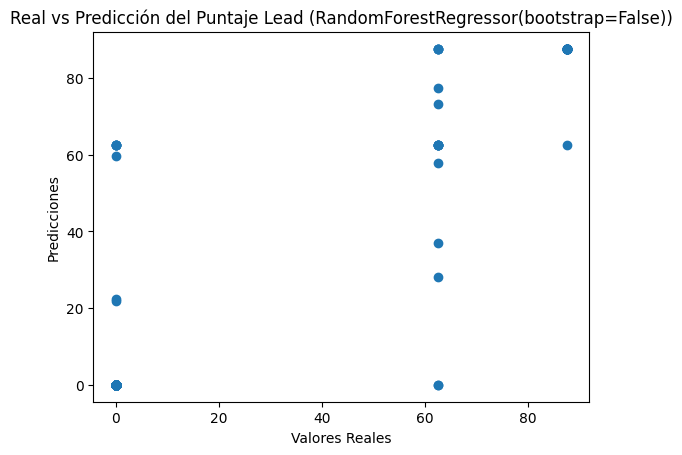

In [100]:
# Visualización de los resultados
plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Real vs Predicción del Puntaje Lead ({mejor_modelo})')
plt.show()

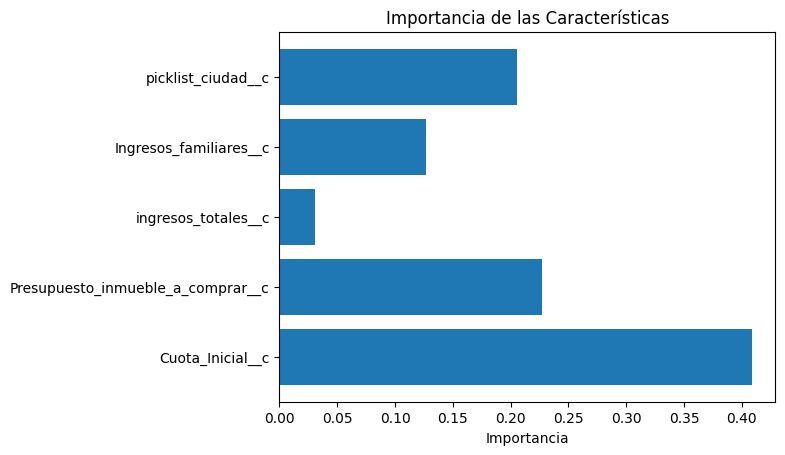

In [101]:
# Visualización de la importancia de las características
if hasattr(mejor_modelo, 'feature_importances_'):
    importancias = mejor_modelo.feature_importances_
    nombres_caracteristicas = X.columns
    plt.barh(nombres_caracteristicas, importancias)
    plt.xlabel('Importancia')
    plt.title('Importancia de las Características')
    plt.show()

In [102]:
# Aplicar la puntuación basada en la importancia de cada característica
puntajes_importancia = X_test.dot(importancias)

In [103]:
# Escalar las puntuaciones entre 0 y 100
escalador_minmax = MinMaxScaler(feature_range=(0, 100))
puntajes_importancia_escalados = escalador_minmax.fit_transform(puntajes_importancia.reshape(-1, 1))

In [104]:
# Guardar el modelo
with open('mejor_modelo_calidad_lead.pkl', 'wb') as file:
    pickle.dump(mejor_modelo, file)